It is quite natural to consider the Internet as a **directed graph**, where **nodes** represent web pages and **edges** represent hyperlinks.  

Suppose the Internet consists of only **4 pages**, and consider the following **web graph** as an example.

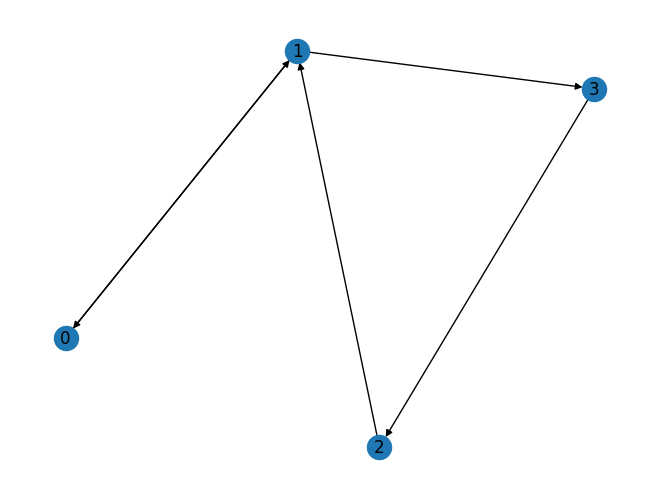

In [1]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0), (0, 1)])
nx.draw(G, with_labels=True)

**Adjacency Matrix**

In [2]:
import numpy as np

A = np.array(nx.adjacency_matrix(G).todense()).T
A

array([[0, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

**Degree Matrix**

In [3]:
degrees = [val//2 for (node, val) in G.degree()]
D = np.diag(degrees)
D

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

This matrix represents the number of outgoing edges from each node. We normalize the adjacency matrix **A** by the degree of each node to obtain the **transition matrix M**, which represents the probability of transition at each node.

**Transition Matrix**  

$$M = A D^{-1}$$

In [4]:
M = A @ np.linalg.inv(D)
M

array([[0. , 0.5, 0. , 0. ],
       [1. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ],
       [0. , 0.5, 0. , 0. ]])

In [5]:
def calculate_transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense()).T
    degrees = [val//2 for (node, val) in G.degree()]
    D = np.diag(degrees)
    M = A @ np.linalg.inv(D)
    return M

Each column of **M** satisfies the **axioms of probability** (for each column, all elements are **non-negative**, and the **sum equals 1**).

### Random Surfer 

Consider a **random user** who explores the Internet by simply clicking on hyperlinks on the current page **at random**.  

For example, if the random visitor is on **page 2**, the next page could be **page 0 or page 3** with a **50-50 probability**.  

#### How often does this random visitor land on each page?
Let **$v$** be the **probability distribution** over the 4 pages, initialized as a **uniform distribution**.  

We can find the answer by **iteratively multiplying the transition matrix $M$ from the left**:

$$v_{k+1} = M v_k$$

This represents a **Markov chain**, where after multiple iterations, the distribution **converges to a steady-state probability**.

In [6]:
initial = np.ones(len(G.nodes())) / len(G.nodes())

initial

array([0.25, 0.25, 0.25, 0.25])

In [7]:
initial = np.ones(len(G.nodes())) / len(G.nodes())
print(0, initial)
for i in range(1, 50):
    initial = M @ initial
    print(i, np.round(initial, 3))

0 [0.25 0.25 0.25 0.25]
1 [0.125 0.5   0.25  0.125]
2 [0.25  0.375 0.125 0.25 ]
3 [0.188 0.375 0.25  0.188]
4 [0.188 0.438 0.188 0.188]
5 [0.219 0.375 0.188 0.219]
6 [0.188 0.406 0.219 0.188]
7 [0.203 0.406 0.188 0.203]
8 [0.203 0.391 0.203 0.203]
9 [0.195 0.406 0.203 0.195]
10 [0.203 0.398 0.195 0.203]
11 [0.199 0.398 0.203 0.199]
12 [0.199 0.402 0.199 0.199]
13 [0.201 0.398 0.199 0.201]
14 [0.199 0.4   0.201 0.199]
15 [0.2   0.4   0.199 0.2  ]
16 [0.2   0.399 0.2   0.2  ]
17 [0.2 0.4 0.2 0.2]
18 [0.2 0.4 0.2 0.2]
19 [0.2 0.4 0.2 0.2]
20 [0.2 0.4 0.2 0.2]
21 [0.2 0.4 0.2 0.2]
22 [0.2 0.4 0.2 0.2]
23 [0.2 0.4 0.2 0.2]
24 [0.2 0.4 0.2 0.2]
25 [0.2 0.4 0.2 0.2]
26 [0.2 0.4 0.2 0.2]
27 [0.2 0.4 0.2 0.2]
28 [0.2 0.4 0.2 0.2]
29 [0.2 0.4 0.2 0.2]
30 [0.2 0.4 0.2 0.2]
31 [0.2 0.4 0.2 0.2]
32 [0.2 0.4 0.2 0.2]
33 [0.2 0.4 0.2 0.2]
34 [0.2 0.4 0.2 0.2]
35 [0.2 0.4 0.2 0.2]
36 [0.2 0.4 0.2 0.2]
37 [0.2 0.4 0.2 0.2]
38 [0.2 0.4 0.2 0.2]
39 [0.2 0.4 0.2 0.2]
40 [0.2 0.4 0.2 0.2]
41 [0.2 0.4 0.2 0

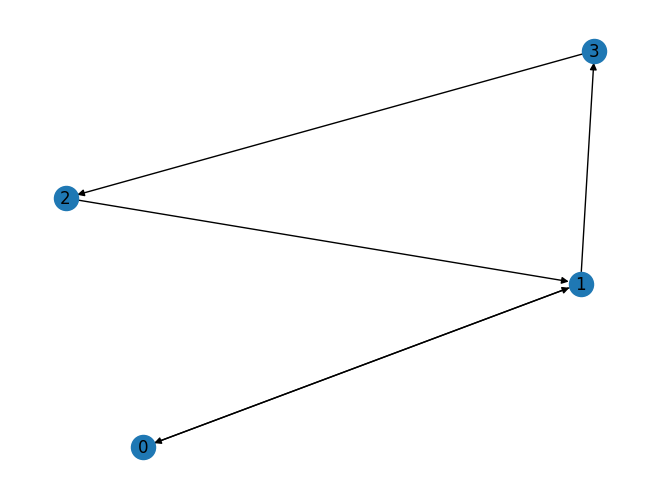

In [9]:
nx.draw(G, with_labels=True)

Finally, we have reached the answer. The **random user** visits **page 1 for 40% of the time** and **pages 0, 2, and 3 for 20% of the time** each.  

This **final probability distribution** is called **PageRank** (some technical details are provided below) and serves as a **measure of importance** for web pages.

Note that the **iterative multiplication** described above **converges** to the steady-state **PageRank vector** $v$.  

This is equivalent to computing the **eigenvector corresponding to the eigenvalue 1** using the **power iteration method** (a.k.a. **power iteration**).

To understand what is happening, let's also calculate **PageRank manually**.

In [10]:
def initialize_node_points(G):
    initial = [1 / G.number_of_nodes() for _ in range(G.number_of_nodes())]
    return G, initial


iteration_counter = 0
def update_node_points(G, previous_node_points):
    global iteration_counter
    iteration_counter += 1
    updated_node_points = [0 for _ in range(G.number_of_nodes())]
    for node in G.nodes():
        node_references = G.out_edges(node)
        if len(node_references) == 0:
            updated_node_points[node] += previous_node_points[node]
        else:
            share = previous_node_points[node] / len(node_references)
            for each_reference in node_references:
                updated_node_points[each_reference[1]] += share
    return updated_node_points, iteration_counter


def keep_updating_until_convergence(G, initial_node_points):
    convergence_value = 0.00001
    previous_node_points = initial_node_points
    while True:
        updated_node_points, iteration_counter = update_node_points(G, previous_node_points)
        for index in range(G.number_of_nodes()):
            if abs(updated_node_points[index] - previous_node_points[index]) > convergence_value:
                break
        else:
            return updated_node_points, iteration_counter
        previous_node_points = updated_node_points

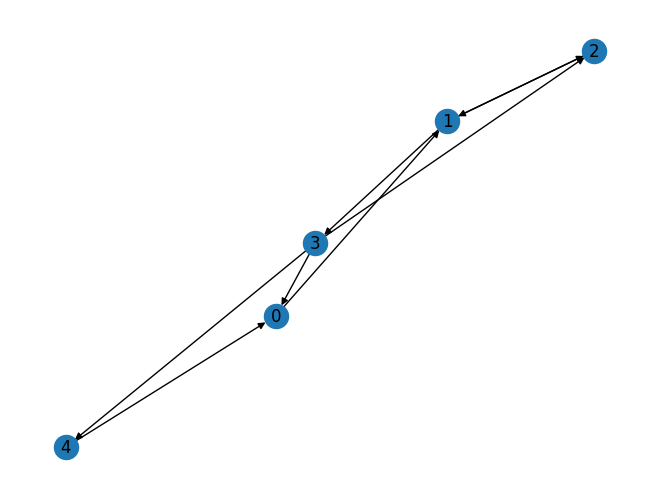

In [11]:
G = nx.DiGraph()
nodes = [i for i in range(0, 5)]
edges = [(0,1), (1,2), (1,3), (2,1), (3,0), (3,2), (3,4), (4,0)]
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

In [12]:
G, initial_node_points = initialize_node_points(G)
pageranks, iteration_counter = keep_updating_until_convergence(G, initial_node_points)
pageranks_array = np.array(pageranks)


print('Iteration counter:', iteration_counter)
print('Pageranks:', pageranks_array)

Iteration counter: 21
Pageranks: [0.1250008  0.3749975  0.25000085 0.1875021  0.06249875]


## Problems with the Approach

### Dangling Nodes

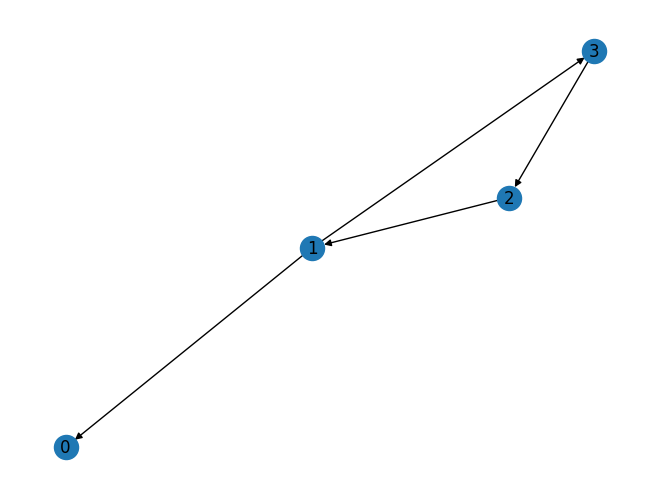

In [13]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0)])
nx.draw(G, with_labels=True)

**Dangling nodes** trap the **random visitor**, causing the **PageRank of other pages to become zero**.  

To prevent this, we **add virtual edges** from these nodes to **all other nodes**. With this adjustment, the **random surfer** who gets stuck at a **dangling node** can randomly jump to other pages.  

The updated **transition matrix** for the given graph is:
$$M = \begin{pmatrix}
0 & 1/2 & 0 & 0\\
1/3 & 0 & 1 & 0\\
1/3 & 0 & 0 & 1\\
1/3 & 1/2 & 0 & 0\\
\end{pmatrix}$$

### Isolated Graph Components

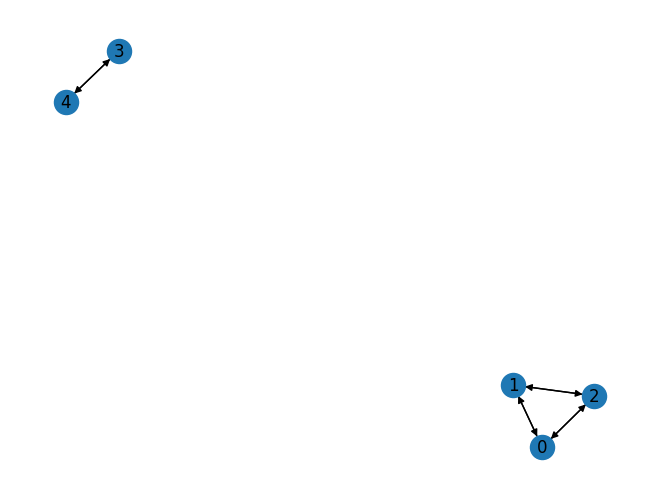

In [14]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (4, 3), (3, 4)])
nx.draw(G, with_labels=True)

In such cases, the **transition matrix** is **block-diagonal** and has **multiple linearly independent eigenvectors** corresponding to the **eigenvalue 1**.

In [15]:
calculate_transition_matrix(G)

array([[0. , 0.5, 0.5, 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

To solve this problem, the creators of **PageRank** introduced the **damping factor** $d$:

$$M = (1-d)M + \frac{d}{n}J_n$$

where:  
- $n$ is the number of nodes,  
- $J_n$ is a **matrix of ones**.  

This **reformulated transition matrix** is also called the **Google Matrix**.  

### Why is the Google Matrix Important?
- It ensures that **all nodes remain connected**, making **PageRank vectors unique** for web graphs.  
- It **prevents infinite loops** in cyclic surfing, which would make the **power method** ineffective.  
- **Intuition:** The **damping factor** allows a **bored random surfer** to **jump to a random page** with probability $d$.

### Questions

Above, we stated that the **iterative calculation of PageRank** is equivalent to computing the **eigenvector corresponding to the eigenvalue 1**. However, some questions arise:  

1. **Does the Google transition matrix always have eigenvalue 1 with multiplicity one?**  
2. **Does the iterative calculation always converge to a unique vector?**  
3. **How fast does the convergence occur?**  

#### Perron–Frobenius Theorem

From the [theorem](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%A4%D1%80%D0%BE%D0%B1%D0%B5%D0%BD%D0%B8%D1%83%D1%81%D0%B0_%E2%80%94_%D0%9F%D0%B5%D1%80%D1%80%D0%BE%D0%BD%D0%B0), since the matrix **M** is **positive** and **column-stochastic**, it follows that:

1. **M has eigenvalue 1 with multiplicity one.**  
2. **1 is the largest eigenvalue**: all other eigenvalues have absolute values less than 1.  
3. **For eigenvalue 1, there exists a unique eigenvector whose elements sum to 1.**  

A proof can be found [here](https://sites.math.northwestern.edu/~clark/354/2002/perron.pdf).  

These statements indicate that there exists a **unique eigenvector** for eigenvalue **1**, with elements summing to **1**.  

**In simple terms**, to compute **PageRank**, we only need to find the **eigenvector** corresponding to **eigenvalue 1**.

### Power Method

The **Power Method** is a **numerical algorithm** used to compute the **eigenvalue with the largest magnitude** and its corresponding **eigenvector**.  

We know that the **largest eigenvalue of the Google matrix $M$ is 1**, so the **Power Method** is straightforward:  
- Simply **iteratively multiply** $M$ by any **initial vector**.  

Denoting the **largest eigenvalue** and the **second-largest eigenvalue (by magnitude)** as $\lambda_1$ and $\lambda_2$, respectively, the **rate of convergence** is given by:

$$\left| \frac{\lambda_2}{\lambda_1} \right| = |\lambda_2|$$

This determines **how quickly** the method **converges to the PageRank vector**.

### Implementation

That concludes the **theoretical part** of **PageRank**.  

**PageRank** can be computed in two ways:  
1. **Eigen decomposition method**  
2. **Power method**

In [13]:
import networkx as nx
import numpy as np


def get_google_matrix(G, d=0.15):
    n = G.number_of_nodes()
    A = nx.to_numpy_array(G).T
    # for sink nodes
    is_sink = np.sum(A, axis=0)==0
    B = (np.ones_like(A) - np.identity(n)) / (n-1)
    A[:, is_sink] += B[:, is_sink]
    
    D_inv = np.diag(1/np.sum(A, axis=0))
    M = np.dot(A, D_inv) 
    
    # for disconnected components
    M = (1-d)*M + d*np.ones((n,n))/n
    return M

def l1(x):
    return np.sum(np.abs(x))

The first solution is **eigen decomposition** of the **Google matrix**.  

The **L1-normalized eigenvector** corresponding to the **largest eigenvalue** (=1) is the **PageRank vector**.

In [38]:
def pagerank_edc(G, d=0.15):
    M = get_google_matrix(G, d=d)
    eigenvalues, eigenvectors = np.linalg.eig(M)
    idx = eigenvalues.argsort()[-1]
    largest = np.array(eigenvectors[:,idx]).flatten().real
    return largest / l1(largest)

In [39]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(1, 3), (3, 2), (2, 1), (1, 0), (0, 1)])
pagerank_edc(G)

array([0.20195025, 0.38694178, 0.20915772, 0.20195025])

### What is the complexity of the algorithm?

The **time complexity** is **$O(n^3)$**, since **eigen decomposition** is a computationally expensive operation.  

For a graph with **more than a trillion nodes** (web pages), this solution becomes **too costly** to compute efficiently.

### Power Method

The method initializes $v_0$ as a **uniform distribution** and **iteratively multiplies** the **Google matrix** until it **converges** or reaches the **maximum number of iterations**.

In [37]:
def pagerank_power(G, d=0.15, max_iter=100, eps=1e-9):
    M = get_google_matrix(G, d=d)
    n = G.number_of_nodes()
    V = np.ones(n)/n
    for _ in range(max_iter):
        V_last = V
        V = np.dot(M, V)
        if  l1(V - V_last) / n < eps:
            return V
    return V

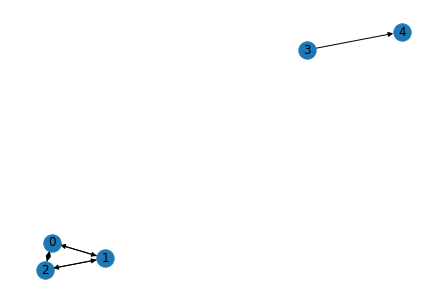

In [48]:
G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (3, 4)])
nx.draw(G, with_labels=True)

In [49]:
pagerank_power(G)

array([0.29595728, 0.29595728, 0.29595728, 0.04439359, 0.06773455])

Regarding **complexity**, the most computationally expensive part of this algorithm is **matrix-vector multiplication**since the number of iterations is limited by **max_iter**.  

- Therefore, the **time complexity** is **$O(n^2)$**.  
- This can be further **optimized to $O(n)$** using **sparse matrix multiplication**.  

**Reminder:**  
The **Google matrix** is a **weighted sum** of:  
1. The **transition matrix** (**sparse!**)  
2. The **matrix of ones** (a simple summation operator).

In [40]:
def gen_webgraph(n, m):
    G = nx.DiGraph(nx.barabasi_albert_graph(n,m))
    rands = np.random.choice(n, n//2, replace=False)
    G.remove_edges_from(np.array(G.edges)[rands])
    return G

In [42]:
import time


number_of_nodes = range(100, 1600, 200)
times_edc = []
times_power = []
for n in number_of_nodes:
    G = gen_webgraph(n, 50)
    
    st = time.time()
    pagerank_edc(G)
    times_edc.append(time.time() - st)
    
    st = time.time()
    pagerank_power(G)
    times_power.append(time.time() - st)

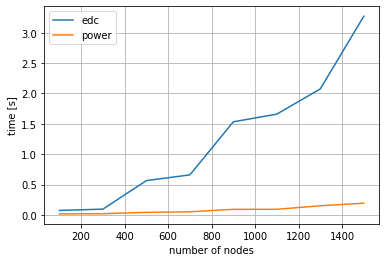

In [43]:
import matplotlib.pylab as plt


plt.grid()
plt.plot(list(number_of_nodes), times_edc, label='edc')
plt.plot(list(number_of_nodes), times_power, label='power')
plt.xlabel("number of nodes")
plt.ylabel("time [s]")
plt.legend()
plt.show()

As we can see, the **power method** is **faster** than **eigen decomposition**, especially when we have a **large number of nodes**.

There are some extensions, such as **Personalized PageRank**, which uses **user-biased distributions** instead of the **uniform distribution** $J_n$ for computing the **Google matrix**.

In [20]:
def pagerank_with_personalization(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None
):
    if len(G) == 0:
        return {}

    D = G.to_directed()

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = sum(nstart.values())
        x = {k: v / s for k, v in nstart.items()}

    if personalization is None:
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        s = sum(personalization.values())
        p = {k: v / s for k, v in personalization.items()}

    if dangling is None:
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        s = sum(dangling.values())
        dangling_weights = {k: v / s for k, v in dangling.items()}
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for _, nbr, wt in W.edges(n, data=weight):
                x[nbr] += alpha * xlast[n] * wt
            x[n] += danglesum * dangling_weights.get(n, 0) + (1.0 - alpha) * p.get(n, 0)
        # check convergence, l1 norm
        err = sum(abs(x[n] - xlast[n]) for n in x)
        if err < N * tol:
            return x

{0: 0.1724140124772394,
 1: 0.3275859875227606,
 2: 0.3275859875227606,
 3: 0.1724140124772394}

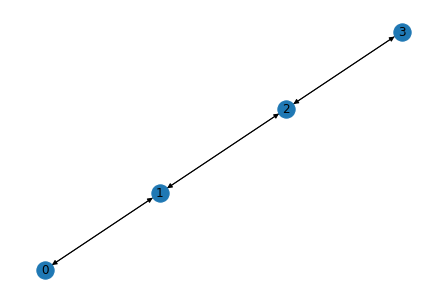

In [45]:
G = nx.DiGraph(nx.path_graph(4))

nx.draw(G, with_labels=True)
nx.pagerank(G, alpha=0.9)